# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sb
import pickle
import math 

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler 
#TSNE
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup


In [2]:
# Temporarily Suppressing Warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# [1]. Reading Data

In [3]:
# using the SQLite Table to read data.
# con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite')

con = sqlite3.connect('D:/Appliedai/Data/amazon-fine-food-reviews/database.sqlite')

#filetering only positve and negative reviews
#reviews not taking in to consideration with score = 3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 40000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition( x ):
    if x > 3:
        return 1 #positive
    else:
        return 0 #negative

#changing reviews with score less than 3 to be positive and vice versa
actual_score = filtered_data['Score']
positivenegative = actual_score.map(partition)
filtered_data['Score']=positivenegative
print('Number of data point in our data',filtered_data.shape)
filtered_data.head(5)    

Number of data point in our data (40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""",con)

In [5]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending= True, inplace=False, kind ='quicksort',na_position='last')

In [7]:
#Duplication of entries
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep = 'first' , inplace= False)
final.shape

(37415, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.5375

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions
    

In [9]:
display = pd.read_sql_query("""
SELECt * 
FROM Reviews
WHERE Score !=3 AND Id=44737 OR Id=64422
ORDER BY ProductId
""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [11]:
final.shape
final['Score'].value_counts()

1    31324
0     6091
Name: Score, dtype: int64

# Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [14]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
# for sentance in tqdm(final['Text'].values):
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_reviews.append(sentance.strip())

In [15]:
# Add pre processed reviews in to final df
# final['preprocessed_reviews'] = preprocessed_reviews

In [16]:
preprocessed_reviews[100]

'fed canidae als old formula years dogs thrived canidae switched formula mfg immediately switched another food afer reported problems feed store talked trying new formula went back als big mistake experienced weight loss explosive diarreha vomitting lethargy etc dogs lbs varying pedigrees ages sick weight loss poor coats vomitting etc run complete extensive blood panels rule health problems dogs bottomline blood panels ok food canidae issue use fantastic food dangerous food feed entire pack dogs health declined new formula switched foods something canidae dogs recovering love las vegas russian roulette feed canidae want avoid major vet expenses heartache choose another food homework research canidae als problems make best educated decision pets year since originally posted review product thought time update still warn folks feeding canidae als canidae formuals not know dogs recovered thank goodness back running fenceline greeting visitors etc not sickly become aka lethergic diarreha lo

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [17]:
##preprocessing for review summary also.

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
# for sentance in tqdm(final['Summary'].values):
for sentance in (final['Summary'].values):

    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_summary.append(sentance.strip())

C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [18]:
preprocessed_summary[100]

'terrible dangerous feed'

# Featurization

BAG OF WORDS, Bi-Grams and n-Grams, TF-IDF, Word2Vec, Converting text into vectors using wAvg W2V, TFIDF-W2V, Avg W2v, TFIDF weighted W2v

In [19]:
#storing label i.e positive and negative in another variable for tsne plot
labels = final['Score'] 




## BAG OF WORDS

In [20]:
#BOW
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)
print('some feature names are',count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words",final_counts.get_shape()[1])

some feature names are ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaand', 'aaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (37415, 35636)
the number of unique words 35636


## Bi-Grams and n-Grams.

In [21]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
count_vect = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams",final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer (37415, 5000)
the number of unique words including both unigrams and bigrams 5000


## TF-IDF

In [22]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df =10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[:10])
print('='*50)
final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able figure', 'able find', 'able finish']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (37415, 22294)
the number of unique words including both unigrams and bigrams  22294


##  Word2Vec

In [23]:
# Train your own Word2Vec model using your own text corpus
# i = 0
list_of_sentance = []
for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance)
    list_of_sentance.append(sentance.split())
# print((list_of_sentance))

In [24]:
# Using Google News Word2Vectors
is_your_ram_gt_16gb = False
want_to_use_google_w2v = True
want_to_train_w2v = True

# print(list_of_sentance)

if want_to_train_w2v:
   # min_count = 5 considers only words that occured atleast 5 times
    w2v_model = Word2Vec(list_of_sentance,min_count = 5 ,size = 50 ,workers = 4)
    print(type(w2v_model))
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    

elif want_to_use_google_w2v and is_your_ram_gt_16gb :
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary = True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")    



<class 'gensim.models.word2vec.Word2Vec'>
[('awesome', 0.8184202313423157), ('fantastic', 0.8099757432937622), ('excellent', 0.7861090898513794), ('amazing', 0.775448739528656), ('wonderful', 0.7705572843551636), ('good', 0.7640385627746582), ('terrific', 0.7386143803596497), ('perfect', 0.7273669242858887), ('fabulous', 0.7049498558044434), ('decent', 0.6865615844726562)]
[('greatest', 0.7276381850242615), ('closest', 0.7116490602493286), ('best', 0.7077579498291016), ('awful', 0.6856242418289185), ('hottest', 0.6576672792434692), ('eaten', 0.6573429107666016), ('nastiest', 0.6470666527748108), ('hardly', 0.6354508399963379), ('experienced', 0.6341041326522827), ('ive', 0.6276416778564453)]


In [25]:
print(type(w2v_model))
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

<class 'gensim.models.word2vec.Word2Vec'>
number of words that occured minimum 5 times  11636
sample words  ['dogs', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'made', 'china', 'satisfied', 'safe', 'loves', 'chicken', 'product', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## Converting text into vectors using wAvg W2V, TFIDF-W2V


####  Avg W2v

In [26]:
#average word2vec
#compute average word2 vec for each review
sent_vectors = [];
# for sent in tqdm(list_of_sentance):
for sent in (list_of_sentance):
    
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words = 0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec  /=cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))        



37415
50


####  TFIDF weighted W2v

In [27]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(),list(model.idf_)))


In [28]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names()

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = [] ; # the tfidf-w2v for each sentence/review is stored in this list
row = 0
# for sent in tqdm(list_of_sentance):
for sent in (list_of_sentance):  
    sent_vec = np.zeros(50)
    weight_sum = 0; # as word vectors are of zero length
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

In [29]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from collections import Counter



In [30]:
x = preprocessed_reviews
y = final['Score'].values


#Train CV test split

x1, base_x_test, y1, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
base_x_train, base_x_cv, y_train, y_cv = train_test_split(x1,y1, test_size = 0.3)

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


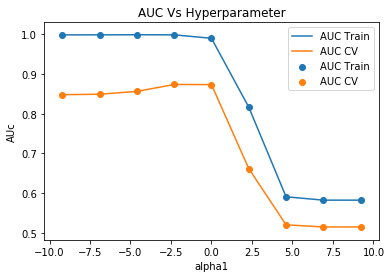

optimal alpha for which auc is max is  0.1


In [31]:
cnt_vec = CountVectorizer()
tran_x_train = cnt_vec.fit_transform(base_x_train)
tran_x_cv = cnt_vec.transform(base_x_cv)
tran_x_test = cnt_vec.transform(base_x_test)

#standardize data
scalar = StandardScaler(with_mean = False)
x_train = scalar.fit_transform(tran_x_train)
x_cv = scalar.transform(tran_x_cv)
x_test = scalar.transform(tran_x_test)

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C

auc_train = []
auc_cv = []

for i in alpha :
    model = SGDClassifier(alpha = i)# default hinge
    clf = CalibratedClassifierCV(model,cv = 3) # caliculation of predict_proba
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

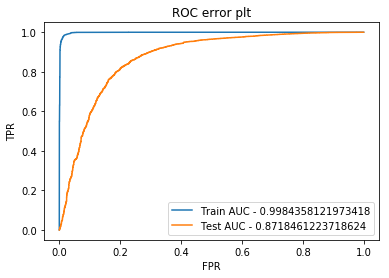

In [32]:
#Train the model with optimal alpha 
#ROC

model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv = 3)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


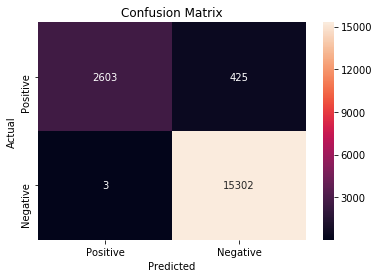

Confusion matrix of test data


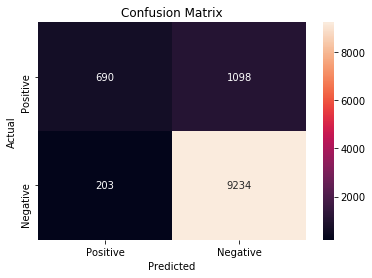

In [33]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



#### Top 10 important features of positive class

In [34]:
fn = cnt_vec.get_feature_names()
model = SGDClassifier(alpha = optimal_alpha)
model.fit(x_train,y_train)
w = model.coef_
pos_words = np.argsort(w)[:,::-1]
neg_words = np.argsort(w)

# for word in neg_words[0][0:10]: 
#     print(fn[word])

print('Top 10 negative features')
for i in list(pos_words[0][0:10]):
    print(fn[i])

Top 10 negative features
great
good
love
best
loves
delicious
perfect
favorite
nice
excellent


#### Top 10 important features of negative class

In [35]:
print('Top 10 negative features')
for i in list(neg_words[0][0:10]):
    print(fn[i])

Top 10 negative features
disappointed
not
worst
awful
disappointing
terrible
return
waste
horrible
thought


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

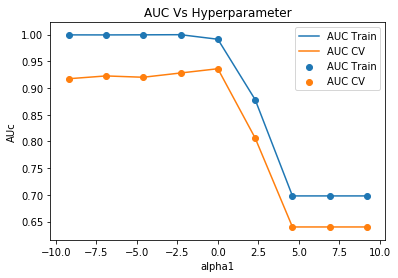

optimal alpha for which auc is max is  1


In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df= 10)
x_train = tf_idf_vect.fit_transform(base_x_train)
x_cv = tf_idf_vect.transform(base_x_cv)
x_test = tf_idf_vect.transform(base_x_test)

#standardize the data 
scalar = StandardScaler(with_mean= False)
x_train =  scalar.fit_transform(x_train)
x_cv =  scalar.transform(x_cv)
x_test =  scalar.transform(x_test)

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C

auc_train = []
auc_cv = []

for i in alpha :
    model = SGDClassifier(alpha = i)# default hinge
    clf = CalibratedClassifierCV(model,cv = 3) # caliculation of predict_proba
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

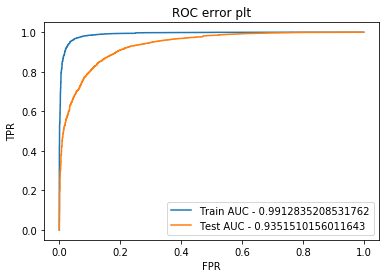

In [37]:
#Train the model with optimal alpha 
#ROC

model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv = 3)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


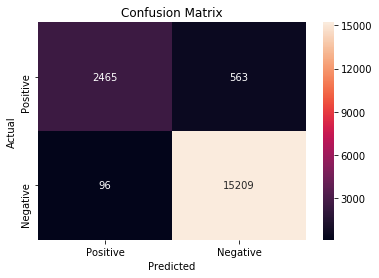

Confusion matrix of test data


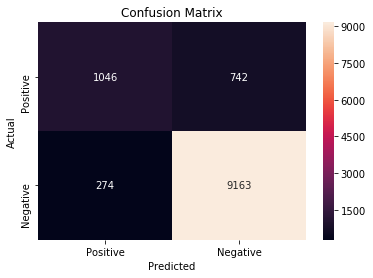

In [38]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



#### Top 10 important features of positive class

In [39]:
fn = tf_idf_vect.get_feature_names()
model = SGDClassifier(alpha = optimal_alpha)
model.fit(x_train,y_train)
w = model.coef_
pos_words = np.argsort(w)[:,::-1]
neg_words = np.argsort(w)

# for word in neg_words[0][0:10]: 
#     print(fn[word])

print('Top 10 negative features')
for i in list(pos_words[0][0:10]):
    print(fn[i])

Top 10 negative features
great
good
love
best
delicious
loves
nice
favorite
perfect
excellent


#### Top 10 important features of negative class

In [40]:
print('Top 10 negative features')
for i in list(neg_words[0][0:10]):
    print(fn[i])

Top 10 negative features
disappointed
worst
not recommend
not worth
return
not buy
horrible
terrible
not purchase
disappointment


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

### Training w2v model

In [41]:
# w2v for train

list_of_sentance_train = []
for sentance in base_x_train:
    list_of_sentance_train.append(sentance.split())
#training w2v model
w2v_model = Word2Vec(list_of_sentance_train, min_count= 5, size = 50, workers = 4 )
w2v_words = list(w2v_model.wv.vocab)

# Converting Train data text

sent_vectors = []
for sent in list_of_sentance_train :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)
print(sent_vectors_train.shape)    

(18333, 50)


In [42]:
#for cross vaidation data
list_of_sentance_cv = []
for sentance in base_x_cv:
    list_of_sentance_cv.append(sentance.split())
    
# Converting Train data text

sent_vectors_cv = []
for sent in list_of_sentance_cv :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)

(7857, 50)


In [43]:
#for test data
list_of_sentance_test = []
for sentance in base_x_test:
    list_of_sentance_test.append(sentance.split())
    
# Converting Train data text

sent_vectors_test = []
for sent in list_of_sentance_test :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)

(11225, 50)


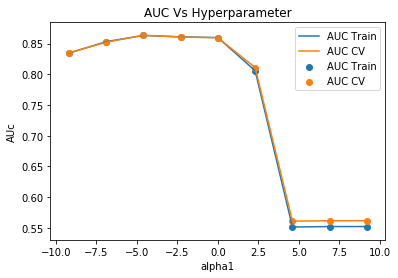

optimal alpha for which auc is max is  0.01


In [44]:
x_train = sent_vectors_train
x_cv = sent_vectors_cv
x_test = sent_vectors_test


alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C
auc_train = []
auc_cv = []
    
for i in alpha :
    model = SGDClassifier(alpha = i)# default hinge
    clf = CalibratedClassifierCV(model,cv = 3) # caliculation of predict_proba
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)
    



#### Testing with Test data

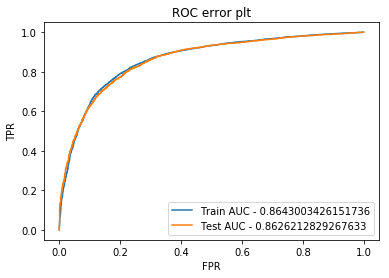

In [45]:

#Train the model with optimal alpha 
#ROC

model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv = 3)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


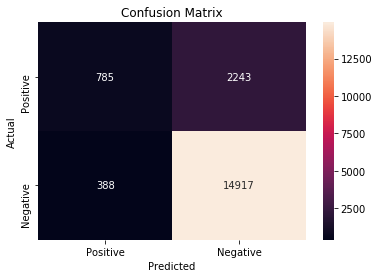

Confusion matrix of test data


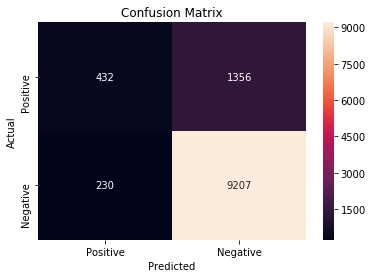

In [46]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [47]:
# w2v for train

list_of_sentance_train = []
for sentance in base_x_train:
    list_of_sentance_train.append(sentance.split())

w2v_model = Word2Vec(list_of_sentance_train , min_count = 5 ,size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)



tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df= 10,max_features= 500)
tf_idf_matrix = tf_idf_vect.fit_transform(base_x_train)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))


In [48]:
# Converting Train data text

tfidf_sent_vectors_train = []
for sent in list_of_sentance_train :
    sent_vec = np.zeros(50)
    weight_sum = 0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+= ( vec * tf_idf )
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec/= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row +=1

In [49]:
list_of_sentance_cv = []
for sentance in base_x_cv:
    list_of_sentance_cv.append(sentance.split())
    
tfidf_sent_vectors_cv = []
row = 0

# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [50]:
#for test data

list_of_sentance_test = []
for sentance in base_x_test:
    list_of_sentance_test.append(sentance.split())
    
tfidf_sent_vectors_test = []
row = 0

# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

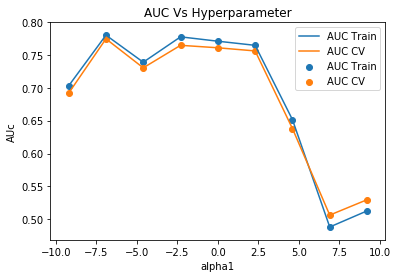

optimal alpha for which auc is max is  0.001


In [51]:
x_train = tfidf_sent_vectors_train
x_cv = tfidf_sent_vectors_cv
x_test = sent_vectors_test

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C
auc_train = []
auc_cv = []
    
for i in alpha :
    model = SGDClassifier(alpha = i)# default hinge
    clf = CalibratedClassifierCV(model,cv = 3) # caliculation of predict_proba
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

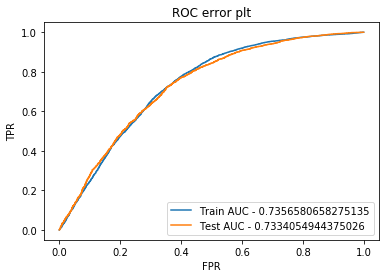

In [52]:
#Train the model with optimal alpha 
#ROC
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv = 3)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


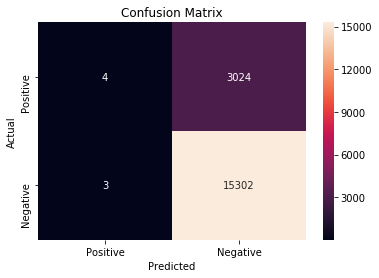

Confusion matrix of test data


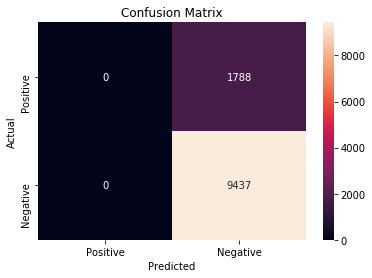

In [53]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


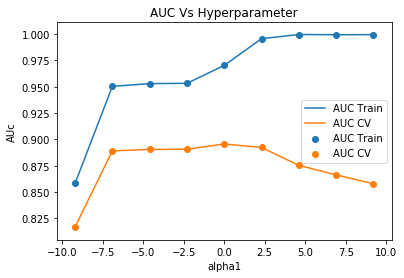

optimal alpha for which auc is max is  1


In [54]:
cnt_vec = CountVectorizer(min_df= 10, max_features= 500)
tran_x_train = cnt_vec.fit_transform(base_x_train)
tran_x_cv = cnt_vec.transform(base_x_cv)
tran_x_test = cnt_vec.transform(base_x_test)

#standardize data
scalar = StandardScaler(with_mean = False)
x_train = scalar.fit_transform(tran_x_train)
x_cv = scalar.transform(tran_x_cv)
x_test = scalar.transform(tran_x_test)

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C

auc_train = []
auc_cv = []

for i in alpha :

    clf = SVC(C = i,probability= True)
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

In [55]:
#Train the model with optimal alpha 
#ROC

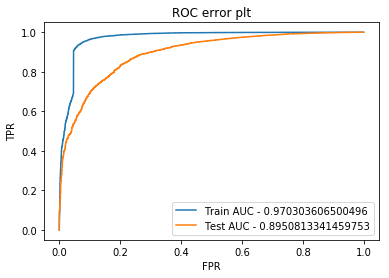

In [56]:
clf = SVC(C = optimal_alpha, probability=True)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


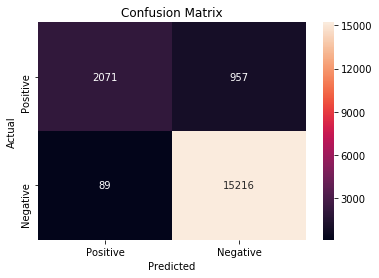

Confusion matrix of test data


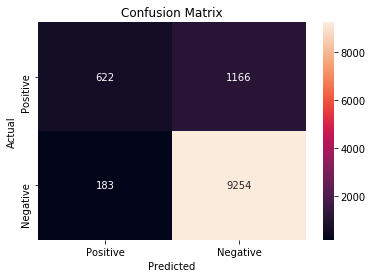

In [57]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

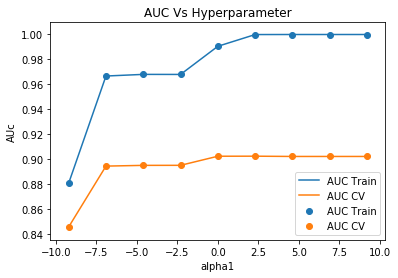

optimal alpha for which auc is max is  10


In [58]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df= 10, max_features=500)
x_train = tf_idf_vect.fit_transform(base_x_train)
x_cv = tf_idf_vect.transform(base_x_cv)
x_test = tf_idf_vect.transform(base_x_test)

#standardize the data 
scalar = StandardScaler(with_mean= False)
x_train =  scalar.fit_transform(x_train)
x_cv =  scalar.transform(x_cv)
x_test =  scalar.transform(x_test)

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C

auc_train = []
auc_cv = []

for i in alpha :
    
    clf = SVC(C = i,probability= True)
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

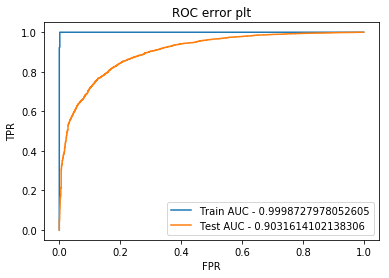

In [59]:
#Train the model with optimal alpha 
#ROC

clf = SVC(C = optimal_alpha,probability= True)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


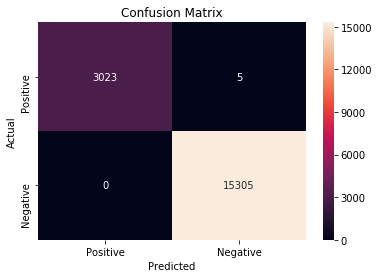

Confusion matrix of test data


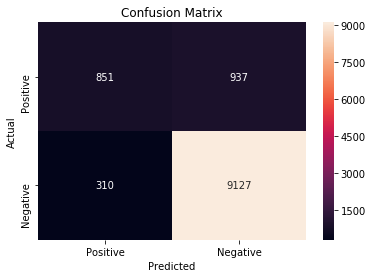

In [60]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [61]:
# w2v for train

list_of_sentance_train = []
for sentance in base_x_train:
    list_of_sentance_train.append(sentance.split())
#training w2v model
w2v_model = Word2Vec(list_of_sentance_train, min_count= 5, size = 50, workers = 4 )
w2v_words = list(w2v_model.wv.vocab)

# Converting Train data text

sent_vectors = []
for sent in list_of_sentance_train :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)
print(sent_vectors_train.shape)    

(18333, 50)


In [62]:
#for cross vaidation data
list_of_sentance_cv = []
for sentance in base_x_cv:
    list_of_sentance_cv.append(sentance.split())
    
# Converting Train data text

sent_vectors_cv = []
for sent in list_of_sentance_cv :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)

(7857, 50)


In [63]:
#for test data
list_of_sentance_test = []
for sentance in base_x_test:
    list_of_sentance_test.append(sentance.split())
    
# Converting Train data text

sent_vectors_test = []
for sent in list_of_sentance_test :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)

(11225, 50)


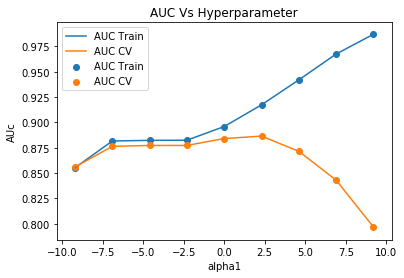

optimal alpha for which auc is max is  10


In [64]:
x_train = sent_vectors_train
x_cv = sent_vectors_cv
x_test = sent_vectors_test


alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C
auc_train = []
auc_cv = []
    
for i in alpha :

    clf = SVC(C = i,probability=True)
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)
    



#### Testing with Test data

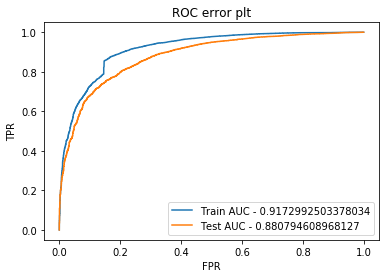

In [65]:
#Train the model with optimal alpha 
#ROC
clf = SVC(C = optimal_alpha, probability= True)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


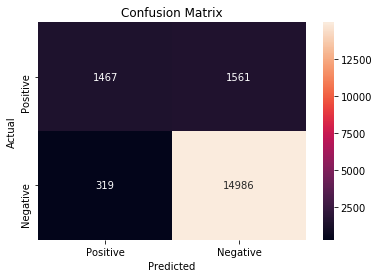

Confusion matrix of test data


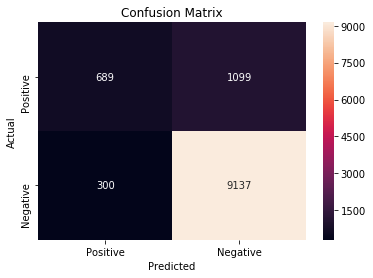

In [66]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [67]:
# w2v for train

list_of_sentance_train = []
for sentance in base_x_train:
    list_of_sentance_train.append(sentance.split())

w2v_model = Word2Vec(list_of_sentance_train , min_count = 5 ,size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)



tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df= 10,max_features= 500)
tf_idf_matrix = tf_idf_vect.fit_transform(base_x_train)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))


In [68]:
# Converting Train data text

tfidf_sent_vectors_train = []
for sent in list_of_sentance_train :
    sent_vec = np.zeros(50)
    weight_sum = 0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+= ( vec * tf_idf )
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec/= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row +=1

In [69]:
list_of_sentance_cv = []
for sentance in base_x_cv:
    list_of_sentance_cv.append(sentance.split())
    
tfidf_sent_vectors_cv = []
row = 0

# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [70]:
#for test data

list_of_sentance_test = []
for sentance in base_x_test:
    list_of_sentance_test.append(sentance.split())
    
tfidf_sent_vectors_test = []
row = 0

# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

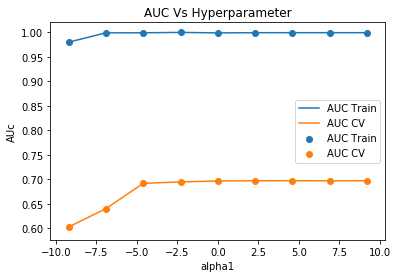

optimal alpha for which auc is max is  100


In [71]:
x_train = tfidf_sent_vectors_train
x_cv = tfidf_sent_vectors_cv
x_test = sent_vectors_test

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C
auc_train = []
auc_cv = []
    
for i in alpha :
    
    clf = SVC(C = i,probability=True)
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

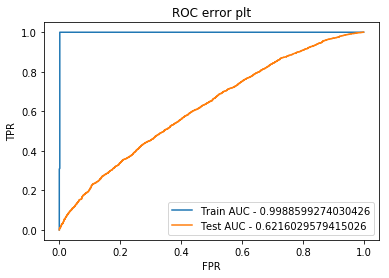

In [72]:
#Train the model with optimal alpha 
#ROC

clf = SVC(C = optimal_alpha,probability= True)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


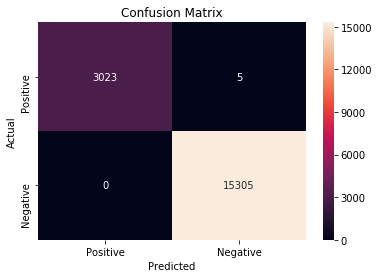

Confusion matrix of test data


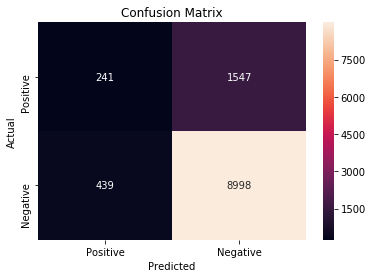

In [73]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## [5.3] Feature engineering

In [74]:
preprocessed_reviews[100]

'fed canidae als old formula years dogs thrived canidae switched formula mfg immediately switched another food afer reported problems feed store talked trying new formula went back als big mistake experienced weight loss explosive diarreha vomitting lethargy etc dogs lbs varying pedigrees ages sick weight loss poor coats vomitting etc run complete extensive blood panels rule health problems dogs bottomline blood panels ok food canidae issue use fantastic food dangerous food feed entire pack dogs health declined new formula switched foods something canidae dogs recovering love las vegas russian roulette feed canidae want avoid major vet expenses heartache choose another food homework research canidae als problems make best educated decision pets year since originally posted review product thought time update still warn folks feeding canidae als canidae formuals not know dogs recovered thank goodness back running fenceline greeting visitors etc not sickly become aka lethergic diarreha lo

In [75]:
#Adding preprocessed summary and review length to preprocessed summary

for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i] += ' '+preprocessed_summary[i]+' '+str(len(final.Text.iloc[i]))

preprocessed_reviews[1000]


'branston pickle say never tried likely wont like grew uk staple cheese cold meat sandwiches lunch sandwich today droool 207'

In [76]:
x = preprocessed_reviews
y = final['Score'].values


#Train CV test split

x1, base_x_test, y1, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
base_x_train, base_x_cv, y_train, y_cv = train_test_split(x1,y1, test_size = 0.3)

#### [5.3.1] BOW

C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saraswathi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


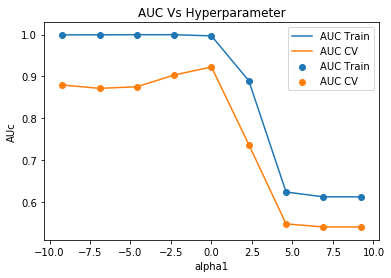

optimal alpha for which auc is max is  1


In [77]:
cnt_vec = CountVectorizer()
tran_x_train = cnt_vec.fit_transform(base_x_train)
tran_x_cv = cnt_vec.transform(base_x_cv)
tran_x_test = cnt_vec.transform(base_x_test)

#standardize data
scalar = StandardScaler(with_mean = False)
x_train = scalar.fit_transform(tran_x_train)
x_cv = scalar.transform(tran_x_cv)
x_test = scalar.transform(tran_x_test)

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C

auc_train = []
auc_cv = []

for i in alpha :
    model = SGDClassifier(alpha = i)# default hinge
    clf = CalibratedClassifierCV(model,cv = 3) # caliculation of predict_proba
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

In [78]:
#Train the model with optimal alpha 
#ROC

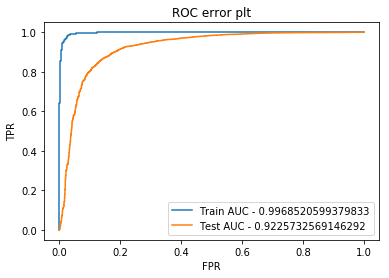

In [79]:
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv = 3)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


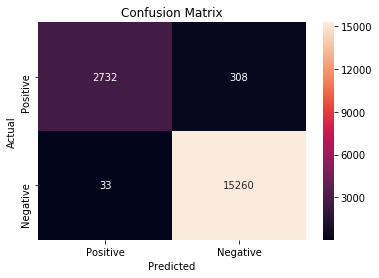

Confusion matrix of test data


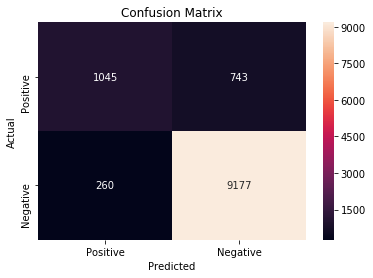

In [80]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



#### Top 10 important features of positive class

In [81]:
fn = cnt_vec.get_feature_names()
model = SGDClassifier(alpha = optimal_alpha)
model.fit(x_train,y_train)
w = model.coef_
pos_words = np.argsort(w)[:,::-1]
neg_words = np.argsort(w)

# for word in neg_words[0][0:10]: 
#     print(fn[word])

print('Top 10 negative features')
for i in list(pos_words[0][0:10]):
    print(fn[i])

Top 10 negative features
great
good
love
best
delicious
loves
excellent
tasty
favorite
nice


#### Top 10 important features of negative class

In [82]:
print('Top 10 negative features')
for i in list(neg_words[0][0:10]):
    print(fn[i])

Top 10 negative features
disappointed
horrible
worst
awful
disappointing
yuck
terrible
waste
return
not


#### [5.3.2] Tfidf

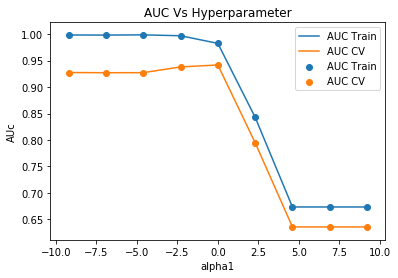

optimal alpha for which auc is max is  1


In [83]:
tf_idf_vect = TfidfVectorizer(min_df= 10)
x_train = tf_idf_vect.fit_transform(base_x_train)
x_cv = tf_idf_vect.transform(base_x_cv)
x_test = tf_idf_vect.transform(base_x_test)

#standardize the data 
scalar = StandardScaler(with_mean= False)
x_train =  scalar.fit_transform(x_train)
x_cv =  scalar.transform(x_cv)
x_test =  scalar.transform(x_test)

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C

auc_train = []
auc_cv = []

for i in alpha :
    model = SGDClassifier(alpha = i)# default hinge
    clf = CalibratedClassifierCV(model,cv = 3) # caliculation of predict_proba
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

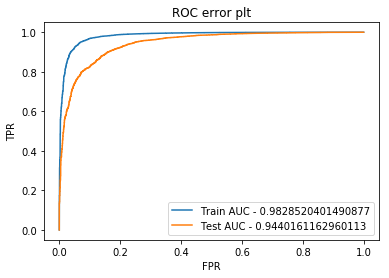

In [84]:
#Train the model with optimal alpha 
#ROC
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv = 3)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

#### Top 10 important features of positive class

In [85]:
fn = tf_idf_vect.get_feature_names()
model = SGDClassifier(alpha = optimal_alpha)
model.fit(x_train,y_train)
w = model.coef_
pos_words = np.argsort(w)[:,::-1]
neg_words = np.argsort(w)

# for word in neg_words[0][0:10]: 
#     print(fn[word])

print('Top 10 negative features')
for i in list(pos_words[0][0:10]):
    print(fn[i])

Top 10 negative features
great
good
love
best
delicious
loves
excellent
nice
perfect
tasty


#### Top 10 important features of negative class

In [86]:
print('Top 10 negative features')
for i in list(neg_words[0][0:10]):
    print(fn[i])

Top 10 negative features
disappointed
worst
horrible
awful
disappointment
waste
disappointing
not
terrible
yuck


#### [5.3.3] Avg W2v

In [87]:
# w2v for train

list_of_sentance_train = []
for sentance in base_x_train:
    list_of_sentance_train.append(sentance.split())
#training w2v model
w2v_model = Word2Vec(list_of_sentance_train, min_count= 5, size = 50, workers = 4 )
w2v_words = list(w2v_model.wv.vocab)

# Converting Train data text

sent_vectors = []
for sent in list_of_sentance_train :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)
print(sent_vectors_train.shape)    

(18333, 50)


In [88]:
#for cross vaidation data
list_of_sentance_cv = []
for sentance in base_x_cv:
    list_of_sentance_cv.append(sentance.split())
    
# Converting Train data text

sent_vectors_cv = []
for sent in list_of_sentance_cv :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)

(7857, 50)


In [89]:
#for test data
list_of_sentance_test = []
for sentance in base_x_test:
    list_of_sentance_test.append(sentance.split())
    
# Converting Train data text

sent_vectors_test = []
for sent in list_of_sentance_test :
    sent_vec = np.zeros(50)
    cnt_vec = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec+= vec
            cnt_vec +=1
    if cnt_words != 0:
        sent_vec/= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)

(11225, 50)


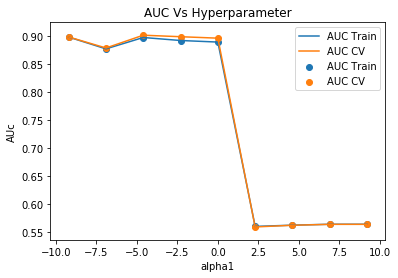

optimal alpha for which auc is max is  0.01


In [90]:
x_train = sent_vectors_train
x_cv = sent_vectors_cv
x_test = sent_vectors_test


alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C
auc_train = []
auc_cv = []
    
for i in alpha :
    model = SGDClassifier(alpha = i)# default hinge
    clf = CalibratedClassifierCV(model,cv = 3) # caliculation of predict_proba
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)
    



#### Testing with Test data

In [91]:

#Train the model with optimal alpha 
#ROC

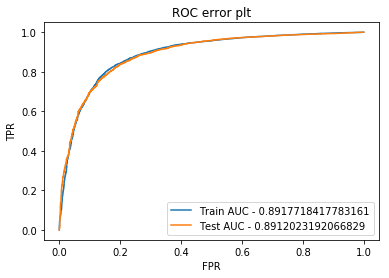

In [92]:
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv = 3)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


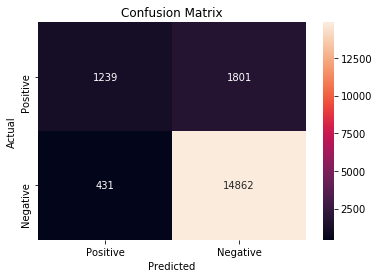

Confusion matrix of test data


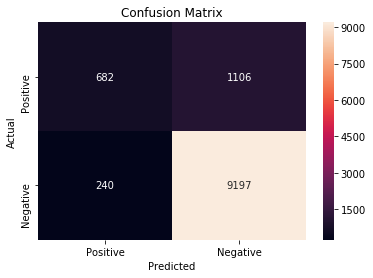

In [93]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



#### [5.3.4] TFIDF W2v

In [94]:
# w2v for train

list_of_sentance_train = []
for sentance in base_x_train:
    list_of_sentance_train.append(sentance.split())

w2v_model = Word2Vec(list_of_sentance_train , min_count = 5 ,size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)



tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df= 10,max_features= 500)
tf_idf_matrix = tf_idf_vect.fit_transform(base_x_train)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))


In [95]:
# Converting Train data text

tfidf_sent_vectors_train = []
for sent in list_of_sentance_train :
    sent_vec = np.zeros(50)
    weight_sum = 0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+= ( vec * tf_idf )
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec/= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row +=1

In [96]:
list_of_sentance_cv = []
for sentance in base_x_cv:
    list_of_sentance_cv.append(sentance.split())
    
tfidf_sent_vectors_cv = []
row = 0

# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [97]:
#for test data

list_of_sentance_test = []
for sentance in base_x_test:
    list_of_sentance_test.append(sentance.split())
    
tfidf_sent_vectors_test = []
row = 0

# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

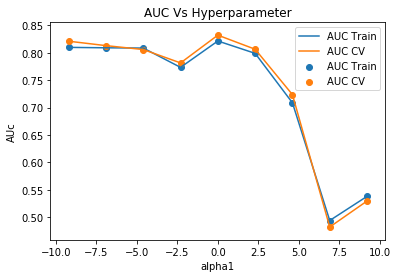

optimal alpha for which auc is max is  1


In [98]:
x_train = tfidf_sent_vectors_train
x_cv = tfidf_sent_vectors_cv
x_test = sent_vectors_test

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3,10**4] #alpha = 1/C
auc_train = []
auc_cv = []
    
for i in alpha :
    model = SGDClassifier(alpha = i)# default hinge
    clf = CalibratedClassifierCV(model,cv = 3) # caliculation of predict_proba
    clf.fit(x_train,y_train)
    
    prob_cv = clf.predict_proba(x_cv)[:,1]
    prob_train  = clf.predict_proba(x_train)[:,1]
    
    auc_cv.append(roc_auc_score(y_cv,prob_cv))
    auc_train.append(roc_auc_score(y_train,prob_train))

optimal_alpha = alpha[auc_cv.index(max(auc_cv))]
alpha = [math.log(x) for x in alpha] #converting values of alpha into logarithm

fig = plt.figure()

plt.plot(alpha, auc_train, label = 'AUC Train')
plt.scatter(alpha, auc_train, label = 'AUC Train')
plt.plot(alpha, auc_cv, label = 'AUC CV')
plt.scatter(alpha, auc_cv, label = 'AUC CV')
    
plt.title('AUC Vs Hyperparameter')
plt.xlabel("alpha1")
plt.ylabel('AUc')
plt.legend()
plt.show()

print('optimal alpha for which auc is max is ', optimal_alpha)

#### Testing with Test data

In [99]:

#Train the model with optimal alpha 
#ROC

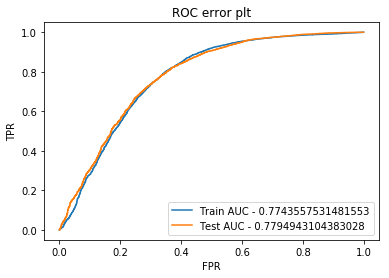

In [100]:
model = SGDClassifier(alpha = optimal_alpha)
clf = CalibratedClassifierCV(model, cv = 3)
clf.fit(x_train,y_train)

train_prob = clf.predict_proba(x_train)[:,1]
test_prob = clf.predict_proba(x_test)[:,1]

train_fpr,train_tpr, tresholds1 =  metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,tresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC - ' + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC error plt')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion matrix of train data


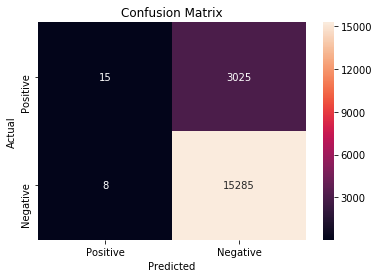

Confusion matrix of test data


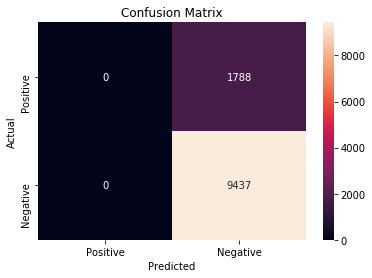

In [101]:
#confusion matrix using heatmap for train data
print('Confusion matrix of train data')
cm = confusion_matrix(y_train,clf.predict(x_train))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion matrix of test data')
cm = confusion_matrix(y_test,clf.predict(x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cm,index= class_labels, columns= class_labels)
sb.heatmap(df, annot= True, fmt = 'd')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



# [6] Conclusions

In [103]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Linear/RBF", "Feature engineering", "Hyperameter(alpha)", "AUC"]
x.add_row(["BOW","linear","Not featured",0.1,0.87])
x.add_row(["TFIDF","linear","Not featured",1,0.93])
x.add_row(["Avg W2v","linear","Not featured",0.01,0.86])
x.add_row(["TFIDF W2v","linear","Not featured",0.001,0.73])
x.add_row(["BOW","RBF","Not featured",1,0.89])
x.add_row(["TFIDF","RBF","Not featured",10,0.90])
x.add_row(["Avg W2v","RBF","Not featured",10,0.88])
x.add_row(["TFIDF W2v","RBF","Not featured",100,0.62])

x.add_row(["BOW","linear","featured",1,0.92])
x.add_row(["TFIDF","linear","featured",0.01,0.94])
x.add_row(["Avg W2v","linear","featured",0.01,0.89])
x.add_row(["TFIDF W2v","linear","featured",1,0.77])
print(x)

+------------+------------+---------------------+--------------------+------+
| Vectorizer | Linear/RBF | Feature engineering | Hyperameter(alpha) | AUC  |
+------------+------------+---------------------+--------------------+------+
|    BOW     |   linear   |     Not featured    |        0.1         | 0.87 |
|   TFIDF    |   linear   |     Not featured    |         1          | 0.93 |
|  Avg W2v   |   linear   |     Not featured    |        0.01        | 0.86 |
| TFIDF W2v  |   linear   |     Not featured    |       0.001        | 0.73 |
|    BOW     |    RBF     |     Not featured    |         1          | 0.89 |
|   TFIDF    |    RBF     |     Not featured    |         10         | 0.9  |
|  Avg W2v   |    RBF     |     Not featured    |         10         | 0.88 |
| TFIDF W2v  |    RBF     |     Not featured    |        100         | 0.62 |
|    BOW     |   linear   |       featured      |         1          | 0.92 |
|   TFIDF    |   linear   |       featured      |        0.01   

Procedure and Observation:-

1) Applied linear SVM using SGD Classifier with hinge loss.

2) Used own for loop to find the bes auc with alpha values from 10^-4 to 10^4.

3) For RBF SVM used the sklearn SVC with 40k points.

4) Applied some feature engineering - added summary and length of review to preprocessed reviews.
